<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/LMS/EXP8_imdb_emotion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 노트북은 modulab의 lms exploration node, imdb감정분석 노트북입니다.


# 2. 네이버 영화 리뷰 감성분석 (8-11 프로젝트)

## 2.(1). 데이터 준비와 확인

google colab에서 쓰기 위해 mecab 설치 : 아무튼 이걸 하니까 됩니다.
참고로 mecab은 원래 일본 전통과자라는 것 같습니다. konlpy 공식 홈페이지로 보이는 곳에서 다운받았습니다만 업데이트가 몇 년 전에 종료됐습니다. 앞으로도 괜찮을까요? 아무튼 일단은 작동합니다.
```python
!apt-get update && apt-get install -y g++ default-jdk
!pip install konlpy
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
```

In [42]:
import pandas as pd
!pip install konlpy
import konlpy
import gensim
import numpy as np

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.3.5
0.6.0
3.6.0


버전이 조금씩 다르지만 크게 다르지는 않습니다. 평소에도 그랬듯 잘 작동하길 기대하면서 일단 진행합니다. 

In [43]:
#import pandas as pd

train_data = pd.read_table('/content/drive/MyDrive/colabdata/modulabs/lms_exp8/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/colabdata/modulabs/lms_exp8/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


google drive에 옮겨둔 파일을 로드합니다. 잘 읽어왔습니다.

## 2.(2) 데이터로더 구성
데이터로더가 너무 길어졌습니다. 뒤늦게 counter의 존재를 알아버렸네요.

In [44]:
from konlpy.tag import Mecab

import numpy as np

num_words=10000
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(inplace=True)
    test_data.drop_duplicates(inplace=True)
    train_data.dropna(inplace=True)
    test_data.dropna(inplace=True)

    train_idx=[]
    test_idx=[]
    
    dict_last_index=0

    appearance={"<PAD>":100,"<BOS>":100, "<UNK>":100}
    #appearance: 전체 데이터에서 등장 횟수.
    #인덱스는 그냥 word로 하겠습니다.
    
    #word to_index, index_to_word 초기화.
    word_to_index={"<PAD>":0, "<BOS>":1, "<UNK>":2}
    index_to_word={0:"<PAD>", 1:"<BOS>", 2:"<UNK>"}

    for sentence in train_data['document']:
        tokens=tokenizer.morphs(sentence)
        token_to_index=[]
        
        for tk in tokens:
            if tk not in stopwords:
                if tk in word_to_index.keys():
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]+=1

                else:
                    index_to_word[dict_last_index]=tk
                    word_to_index[tk]=dict_last_index
                    dict_last_index+=1
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]=1

        train_idx.append(token_to_index)

    for sentence in test_data['document']:
        tokens=tokenizer.morphs(sentence)
        token_to_index=[]
        for tk in tokens:
            if tk not in stopwords:
                if tk in word_to_index.keys():
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]+=1
                else:
                    index_to_word[dict_last_index]=tk
                    word_to_index[tk]=dict_last_index
                    dict_last_index+=1
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]=1

        test_idx.append(token_to_index)
    
    if len(index_to_word)>num_words:
        min=np.min(appearance.values())
        for word, index in word_to_index.items():
            if appearance[word]==min:
                del word_to_index[word] 
                del index_to_word[index]
            if len(index_to_word)<num_words:
                break
    
    
    for i, sentence in enumerate(test_idx):
        for j, token in enumerate(sentence):
            if token not in index_to_word.keys():
                test_idx[i,j]=word_to_index["<UNK>"]
    for i, sentence in enumerate(train_idx):
        for j, token in enumerate(sentence):
            if token not in index_to_word.keys():
                train_idx[i,j]=word_to_index["<UNK>"]

        
    return train_idx, train_data['label'], test_idx, test_data['label'], word_to_index, index_to_word

#index_to_word도 load_data에서 만들었기 때문에 그냥 같이 반환합니다.
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)
print(X_train[:5])


[[0, 1, 2, 3, 3, 4, 5, 6, 7, 8], [9, 3, 10, 11, 12, 13, 14, 15, 3, 16, 17, 18, 19, 20, 21, 22, 23], [24, 25, 26], [27, 28, 29, 3, 3, 30, 31, 32, 33, 3, 3, 34, 35], [36, 37, 38, 18, 39, 40, 14, 41, 42, 43, 44, 45, 46, 47, 48, 49, 40, 50, 51, 52, 53, 54, 33]]


In [45]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [46]:
get_decoded_sentence(X_train[4], index_to_word)

'익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 커스틴 던스트 너무나 이뻐 보였 다'

데이터로더가 잘 작동하는 것 같습니다. 

## 2.(3). 모델 구성을 위한 데이터 분석 및 가공
평균$+2\sigma$으로 자르겠습니다.

In [49]:
length=[len(sentence) for sentence in X_train]
print(np.max(length), np.mean(length), np.std(length))
maxlen=int(np.mean(length)*np.std(length))

116 15.644794826494216 12.841204643969176


In [50]:
import tensorflow as tf
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(149995, 200)


In [51]:
print(x_test.shape, x_train.shape)
print(x_train[356],get_decoded_sentence(x_train[356], index_to_word))


(49997, 200) (149995, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 1845 1567 1846 1847
 1848   48 1849   14 1010  195  115  298 1850 1851

## 2.(4). 모델 구성 및 validation set 구성
일단 이전에 썼던 것을 그대로 해보겠습니다. test용으로 10000개만 남기고 test였던 것을 validation으로 써먹겠습니다.

__모델 바꿔보기__
- 지금은 LSTM 레이어 하나만 했습니다. 왜냐하면 그 전에 그냥 썼던 거라서요. 이걸 늘려 볼 수도 있겠죠.
- Convolution Layer를 넣어 볼 수도 있겠죠.
- Fully Connected Layer


In [52]:
x_valid=x_test[10000:]
y_valid=y_test[10000:]
x_test=x_test[:10000]
y_test=y_test[:10000]

In [54]:
vocab_size = len(word_to_index)+1
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          1969152   
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,978,561
Trainable params: 1,978,561
Non-trainable params: 0
_________________________________________________________________


In [55]:
print(y_train.shape, x_train.shape)
print(len(word_to_index), len(index_to_word))

(149995,) (149995, 200)
61535 61532


## 2.(5). 모델 훈련


In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/20
293/293 [==============================] - 120s 399ms/step - loss: 0.4244 - accuracy: 0.8091 - val_loss: 0.3514 - val_accuracy: 0.8516
Epoch 2/20
293/293 [==============================] - 122s 417ms/step - loss: 0.3012 - accuracy: 0.8763 - val_loss: 0.3460 - val_accuracy: 0.8523
Epoch 3/20
293/293 [==============================] - 120s 410ms/step - loss: 0.2602 - accuracy: 0.8959 - val_loss: 0.3517 - val_accuracy: 0.8509
Epoch 4/20
293/293 [==============================] - 119s 405ms/step - loss: 0.2282 - accuracy: 0.9113 - val_loss: 0.3657 - val_accuracy: 0.8493
Epoch 5/20
293/293 [==============================] - 120s 408ms/step - loss: 0.2019 - accuracy: 0.9225 - val_loss: 0.3857 - val_accuracy: 0.8502
Epoch 6/20
293/293 [==============================] - 119s 407ms/step - loss: 0.1758 - accuracy: 0.9322 - val_loss: 0.4088 - val_accuracy: 0.8483
Epoch 7/20
293/293 [==============================] - 121s 412ms/step - loss: 0.1541 - accuracy: 0.9402 - val_loss: 0.4646 -

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


loss, accuracy가 train - test 사이에서 교차하는 모습이 참 안타깝습니다. 이대로라면 epoch은 2~5정도면 충분해 보입니다.

## 2.(6). Loss, Accuracy 그래프 시각화


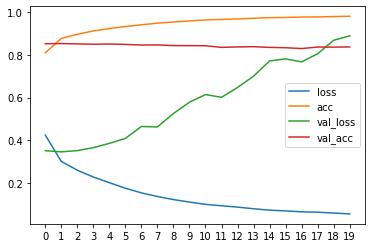

In [66]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.legend()
plt.xticks(ticks=list(range(20)))
plt.show()

## 2.(6). 학습된 embedding 레이어 분석


## 2.(7). 한국어 Word2Vec임베딩 활용하여 성능 개선




# 1. 프로젝트 이전 코드
lms에서 코드를 좀 가져오겠습니다.
-> mecab 설치 너무 번거롭네요. 그냥 lms의 주피터 노트북으로 갑시다 -> 다시 여기서 하기로 하였습니다.  
## 1.1. encode, decode함수
단어를 index(숫자)로 저장했다가 다시 문장으로 해석했다 하는 과정입니다. 여러개 처리하는 것을 function 둘로 나눠놨네요. for loop 표현식을 쓰고 있습니다.

```python
import tensorflow as tf
import numpy as np
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#print(get_encoded_sentence('i eat lunch', word_to_index))

# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 

#encoded_sentences = get_encoded_sentences(sentences, word_to_index)
#print(encoded_sentences)
```

```python
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
#print(get_decoded_sentences(encoded_sentences, index_to_word))
```

## 1.2. IMDB데이터셋 가져오기
tf.keras에 서 데이터를 가져옵니다. 인코딩 된 것이라 사전도 같이 줍니다.

```python
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))


word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

#print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
#print(word_to_index['the'])  # 4 이 출력됩니다. 
#print(index_to_word[4])     # 'the' 가 출력됩니다.

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

#padding: pre 혹은 post로
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)
```

## 1.3. RNN 모델 
```python
vocab_size = 10000
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()
```
```python
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
```
```python
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val), verbose=1)
```